<a href="https://colab.research.google.com/github/paulpark6/WildFire/blob/main/wildfire_prediction_v0_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wildfire Prediction v0.2

- Data Balancing

# Import Packages

In [ ]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow import keras
from sklearn.impute import SimpleImputer

import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score

# Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_og = pd.read_csv('/content/drive/My Drive/EY - Wildfires in Alberta/fp-historical-wildfire-data-2006-2021.csv')

In [ ]:
df_og

,fire_year,fire_number,fire_name,current_size,size_class,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,industry_identifier_desc,...,distance_from_water_source,first_bucket_drop_date,bh_fs_date,bh_hectares,uc_fs_date,uc_hectares,to_fs_date,to_hectares,ex_fs_date,ex_hectares
0,2021,HWF053,NaN,5.50,C,59.522139,-119.926971,Provincial Land,Lightning,NaN,...,NaN,NaN,6/28/21 22:26,0.01,7/1/21 13:26,10.00,NaN,NaN,7/1/21 13:44,5.50
1,2021,RWF005,NaN,0.01,A,52.692262,-116.118960,Provincial Land,Forest Industry,NaN,...,NaN,NaN,3/30/21 14:30,0.01,3/30/21 14:30,0.01,3/30/21 14:35,0.01,4/9/21 8:30,0.01
2,2021,LWF014,NaN,0.10,A,55.937050,-110.719950,Indian Reservation,Incendiary,NaN,...,NaN,NaN,4/16/21 16:57,0.10,4/16/21 16:57,0.10,NaN,NaN,4/17/21 14:15,0.10
3,2021,MWF002,NaN,0.01,A,56.425933,-111.160750,Indian Reservation,Resident,NaN,...,NaN,NaN,4/17/21 15:20,0.01,4/17/21 15:20,0.01,NaN,NaN,4/17/21 15:24,0.01
4,2021,EWF014,NaN,7.13,C,53.693450,-116.058633,Private Land,Resident,NaN,...,NaN,NaN,4/1/21 19:10,7.13,4/2/21 11:00,7.13,4/2/21 15:52,7.13,4/12/21 14:30,7.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22909,2006,CWF231,NaN,0.10,A,51.161883,-114.869317,Indian Reservation,Resident,NaN,...,NaN,NaN,3/11/07 17:35,0.01,3/11/07 17:45,0.01,NaN,NaN,3/11/07 18:00,0.10
22910,2006,CWF232,NaN,0.01,A,51.084150,-115.392633,Provincial Park,Undetermined,NaN,...,NaN,NaN,3/19/07 10:25,0.01,3/19/07 10:25,0.01,NaN,NaN,3/19/07 10:40,0.01
22911,2006,CWF233,NaN,0.70,B,51.333900,-114.997667,Provincial Land,Recreation,NaN,...,NaN,NaN,3/26/07 2:00,0.70,3/26/07 2:00,0.70,NaN,NaN,3/26/07 12:00,0.70
22912,2006,CWF234,NaN,0.01,A,51.071467,-115.316300,Provincial Land,Resident,NaN,...,NaN,NaN,3/28/07 11:00,0.01,3/28/07 11:00,0.01,NaN,NaN,3/28/07 11:30,0.01


In [ ]:
import pandas as pd
from copy import deepcopy

# Step 1: Deep copy the DataFrame
df = deepcopy(df_og)

# Step 2: Count the occurrence of each unique value
value_counts = df['size_class'].value_counts()

# Step 3: Determine the threshold for the 3rd most common value's count
threshold = value_counts.nlargest(3).min()

# Step 4: Drop rows for unique values exceeding the threshold
# We'll iterate over each unique value and its count
for value, count in value_counts.items():
    if count > threshold:
        # Find the indices of rows to drop (those beyond the threshold for this value)
        # We sort by index to ensure we're dropping the "last" ones as per your example
        indices_to_drop = df[df['size_class'] == value].index[-(count - threshold):]
        # Drop these rows from the DataFrame
        df = df.drop(indices_to_drop)

In [ ]:
df['size_class'].value_counts()

C    1060
A    1060
B    1060
E     325
D     302
Name: size_class, dtype: int64

# Fire Size Prediction

In [ ]:
selected_columns = [
    'fire_location_latitude',
    'fire_location_longitude',
    'fire_origin',
    'general_cause_desc',
    'activity_class',
    'true_cause',
    'fire_start_date',
    'fire_spread_rate',
    'fire_type',
    'fire_position_on_slope',
    'weather_conditions_over_fire',
    'temperature',
    'relative_humidity',
    'wind_direction',
    'wind_speed',
    'fuel_type',
]

In [ ]:
df_train = df.loc[:, selected_columns].copy()

In [ ]:
y_fields = df[['size_class']]

In [ ]:
len(df)

3807

In [ ]:
df_train

,fire_location_latitude,fire_location_longitude,fire_origin,general_cause_desc,activity_class,true_cause,fire_start_date,fire_spread_rate,fire_type,fire_position_on_slope,weather_conditions_over_fire,temperature,relative_humidity,wind_direction,wind_speed,fuel_type
0,59.522139,-119.926971,Provincial Land,Lightning,NaN,NaN,6/28/10 9:07,3.0,Surface,Flat,Clear,28.8,37.0,SE,11.0,C2
1,52.692262,-116.118960,Provincial Land,Forest Industry,Debris Disposal,Winter Burning,3/25/20 8:00,0.0,Ground,Flat,Cloudy,2.0,50.0,SE,10.0,NaN
2,55.937050,-110.719950,Indian Reservation,Incendiary,Arson,NaN,4/16/20 16:20,0.5,Surface,Flat,Clear,16.0,19.0,NW,15.0,O1a
3,56.425933,-111.160750,Indian Reservation,Resident,Cooking and Warming,Unsafe Fire,4/16/20 17:00,0.0,Surface,Flat,Cloudy,7.0,55.0,N,14.0,O1a
4,53.693450,-116.058633,Private Land,Resident,Debris Disposal,Unsafe Fire,11/1/20 10:00,5.0,Surface,Flat,Cloudy,12.8,19.0,W,27.0,O1a
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22714,54.697817,-116.218083,Provincial Land,Undetermined,NaN,NaN,9/1/06 12:00,1.0,Ground,Flat,Clear,9.0,43.0,SW,2.0,O1b
22767,55.868800,-115.106883,Provincial Land,Power Line Industry,Power Lines,Unpredictable Event,9/8/06 14:03,2.0,Crown,Flat,Clear,25.0,36.0,SE,30.0,C2
22860,58.498500,-114.955283,Provincial Land,Recreation,All Terrain Vehicles,Hot Exhaust,10/8/06 0:00,6.0,Surface,Flat,Clear,7.0,60.0,NW,10.0,O1a
22871,58.462662,-114.443320,Provincial Land,Resident,Grass,Abandoned Fire,10/14/06 0:00,5.0,Surface,Flat,Cloudy,3.0,50.0,SE,15.0,O1b


In [ ]:
for column in df_train.columns:
    if df_train[column].isnull().any():
        print(f'Column "{column}" contains NaN value(s)')

Column "fire_origin" contains NaN value(s)
Column "activity_class" contains NaN value(s)
Column "true_cause" contains NaN value(s)
Column "fire_start_date" contains NaN value(s)
Column "fire_spread_rate" contains NaN value(s)
Column "fire_type" contains NaN value(s)
Column "fire_position_on_slope" contains NaN value(s)
Column "weather_conditions_over_fire" contains NaN value(s)
Column "temperature" contains NaN value(s)
Column "relative_humidity" contains NaN value(s)
Column "wind_direction" contains NaN value(s)
Column "wind_speed" contains NaN value(s)
Column "fuel_type" contains NaN value(s)


# Filling In NaN Values

In [ ]:
df_train['fire_origin'].value_counts()

Provincial Land       2680
Private Land           558
Indian Reservation     479
Provincial Park         42
DND                     29
Metis Settlement        17
National Park            1
Name: fire_origin, dtype: int64

In [ ]:
df_train['fire_origin'].fillna('Provincial Land', inplace=True)

In [ ]:
df_train['activity_class'].value_counts()

Debris Disposal         334
Cooking and Warming     325
Operations              306
Unclassified            263
Arson                   263
Transportation           84
Grass                    63
OHV Operation            50
Power Lines              41
Refuse Disposal          35
Piles                    34
All Terrain Vehicles     34
Flaring Gas              27
Lighting Fires           24
Structure Fire           19
Cooking                  14
Restart                  11
Windrows                 11
Traditional Burning       8
Refuse                    7
Children                  7
Heavy Equipment           6
Brush                     5
Vehicle Trans.            5
Ammunition                3
Prescribed Fire           3
Slash                     3
Rail Transportation       3
Welders                   1
Power Saw                 1
Name: activity_class, dtype: int64

In [ ]:
df_train['activity_class'].fillna('Unclassified', inplace=True)

In [ ]:
df_train['true_cause'].value_counts()

Unsafe Fire               616
Burning Substance         139
Line Impact               136
Mechanical Failure        113
Winter Burning             89
Permit Related             61
Unclassified               57
Friction Spark             45
Vehicle Fire               44
Abandoned Fire             39
Insufficient Buffer        39
Hot Exhaust                32
Arson Suspected            24
Incendiary Device          22
Unpredictable Event        19
Animals                    15
Unattended Fire             7
High Hazard                 2
Insufficient Resources      2
Arson Known                 1
Name: true_cause, dtype: int64

In [ ]:
df_train['true_cause'].fillna('Unclassified', inplace=True)

In [ ]:
import pandas as pd

df_train['fire_start_date'] = pd.to_datetime(df_train['fire_start_date'], errors='coerce')  # Ensure the column is datetime

# Step 1: Extract the month
df_train['fire_start_date'] = df_train['fire_start_date'].dt.month

# Optional: Convert numeric month to month names for readability
month_names = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 5: 'May', 6: 'June',
               7: 'July', 8: 'August', 9: 'September', 10: 'October', 11: 'November', 12: 'December'}
df_train['fire_start_date'] = df_train['fire_start_date'].map(month_names)

# Step 2: Convert to categorical
df_train['fire_start_date'] = pd.Categorical(df_train['fire_start_date'], categories=month_names.values(), ordered=True)

In [ ]:
df_train['fire_start_date'].value_counts()

May          1038
July          812
June          770
April         452
August        260
September     127
October       112
March          65
January        40
November       38
February       27
December       14
Name: fire_start_date, dtype: int64

In [ ]:
df_train['fire_start_date'].fillna('May', inplace=True)

In [ ]:
df_train['fire_spread_rate'].value_counts()

0.0     1126
1.0      740
2.0      349
5.0      330
3.0      281
0.5      204
0.1      188
10.0     146
4.0       83
15.0      34
7.0       30
20.0      27
1.5       26
8.0       24
0.2       23
6.0       20
25.0      11
30.0      10
0.3        9
2.5        8
12.0       6
9.0        6
50.0       5
13.0       4
3.5        3
0.8        2
0.4        2
0.9        2
18.0       1
34.0       1
60.0       1
11.0       1
65.0       1
16.0       1
1.7        1
4.5        1
0.7        1
Name: fire_spread_rate, dtype: int64

In [ ]:
df_train['fire_spread_rate'].fillna(df_train['fire_spread_rate'].mean(), inplace=True)

In [ ]:
df_train['fire_type'].value_counts()

Surface       2595
Ground         619
Crown          511
   Surface       1
Name: fire_type, dtype: int64

In [ ]:
df_train['fire_type'].fillna('Surface', inplace=True)

In [ ]:
df_train['fire_position_on_slope'].value_counts()

Flat          3054
Bottom         208
Middle 1/3     158
Upper 1/3      156
Lower 1/3      125
Name: fire_position_on_slope, dtype: int64

In [ ]:
df_train['fire_position_on_slope'].fillna('Flat', inplace=True)

In [ ]:
df_train['weather_conditions_over_fire'].value_counts()

Clear          1900
Cloudy         1209
CB Dry          290
CB Wet          186
Rainshowers     114
Name: weather_conditions_over_fire, dtype: int64

In [ ]:
df_train['weather_conditions_over_fire'].fillna('Clear', inplace=True)

In [ ]:
df_train['temperature'].value_counts()

20.0    238
25.0    213
22.0    200
18.0    191
23.0    190
       ... 
28.1      1
29.4      1
24.8      1
21.6      1
0.1       1
Name: temperature, Length: 199, dtype: int64

In [ ]:
df_train['temperature'].fillna(df_train['temperature'].mean(), inplace=True)

In [ ]:
df_train['relative_humidity'].value_counts()

35.0    287
30.0    277
40.0    251
45.0    171
25.0    155
       ... 
1.0       1
2.0       1
4.0       1
11.0      1
5.0       1
Name: relative_humidity, Length: 96, dtype: int64

In [ ]:
df_train['relative_humidity'].fillna(df_train['relative_humidity'].mean(), inplace=True)

In [ ]:
df_train['wind_direction'].value_counts()

W      890
SW     515
NW     487
SE     452
E      285
S      282
CLM    278
N      269
NE     239
Name: wind_direction, dtype: int64

In [ ]:
df_train['wind_direction'].fillna('W', inplace=True)

In [ ]:
df_train['wind_speed'].value_counts()

10.0    640
5.0     554
15.0    401
0.0     278
20.0    239
3.0     163
2.0     146
8.0     138
6.0     117
25.0    106
7.0      95
4.0      91
12.0     81
30.0     75
9.0      58
1.0      51
11.0     50
13.0     46
14.0     40
17.0     35
16.0     34
18.0     34
35.0     33
22.0     22
40.0     20
19.0     14
26.0     13
50.0     13
23.0     11
24.0     10
28.0      8
27.0      8
31.0      7
32.0      7
33.0      6
46.0      5
21.0      5
29.0      5
34.0      4
45.0      4
60.0      3
37.0      3
38.0      3
65.0      3
39.0      2
55.0      2
75.0      2
36.0      2
43.0      2
90.0      2
70.0      1
41.0      1
53.0      1
66.0      1
57.0      1
56.0      1
Name: wind_speed, dtype: int64

In [ ]:
df_train['wind_speed'].fillna(df_train['wind_speed'].mean(), inplace=True)

In [ ]:
df_train['fuel_type'].value_counts()

C2     1365
O1a     824
O1b     353
M2      246
C1      121
M1      111
C3       91
S1       77
D1       67
S2       54
C4       19
C7        5
Name: fuel_type, dtype: int64

In [ ]:
df_train['fuel_type'].fillna('C2', inplace=True)

In [ ]:
import pandas as pd

# Identify string columns in the DataFrame
string_columns = df_train.select_dtypes(include=[object]).columns

# Initialize a DataFrame to hold our one-hot encoded columns
df_train_one_hot_encoded = pd.DataFrame()

# Iterate over each string column to perform one-hot encoding
for column in string_columns:
    # Perform one-hot encoding and ensure unique labeling
    dummies = pd.get_dummies(df_train[column], prefix=column)
    # Concatenate the result to our one_hot_encoded_df DataFrame
    df_train_one_hot_encoded = pd.concat([df_train_one_hot_encoded, dummies], axis=1)

# Concatenate the numeric columns of the original DataFrame to the one_hot_encoded_df
numeric_columns = df_train.select_dtypes(include=[np.number])
df_train_one_hot_encoded = pd.concat([numeric_columns, df_train_one_hot_encoded], axis=1)

# Display the DataFrame with numeric columns and one-hot encoded columns
df_train_one_hot_encoded

,fire_location_latitude,fire_location_longitude,fire_spread_rate,temperature,relative_humidity,wind_speed,fire_origin_DND,fire_origin_Indian Reservation,fire_origin_Metis Settlement,fire_origin_National Park,...,fuel_type_C3,fuel_type_C4,fuel_type_C7,fuel_type_D1,fuel_type_M1,fuel_type_M2,fuel_type_O1a,fuel_type_O1b,fuel_type_S1,fuel_type_S2
0,59.522139,-119.926971,3.0,28.8,37.0,11.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,52.692262,-116.118960,0.0,2.0,50.0,10.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,55.937050,-110.719950,0.5,16.0,19.0,15.0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,56.425933,-111.160750,0.0,7.0,55.0,14.0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,53.693450,-116.058633,5.0,12.8,19.0,27.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22714,54.697817,-116.218083,1.0,9.0,43.0,2.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
22767,55.868800,-115.106883,2.0,25.0,36.0,30.0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22860,58.498500,-114.955283,6.0,7.0,60.0,10.0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
22871,58.462662,-114.443320,5.0,3.0,50.0,15.0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# XGBoost Model - Predict `size_class`

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df_train_one_hot_encoded
y = y_fields['size_class']

# Encode categorical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
model_size_class = xgb.XGBClassifier(
    objective='multi:softprob',
    n_estimators=50,            # Number of boosting rounds (you can adjust this)
    learning_rate=0.1,           # Learning rate (you can adjust this)
    max_depth=4,                 # Maximum depth of each tree (you can adjust this)
    random_state=42
)

In [ ]:
model_size_class.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred = model_size_class.predict(X_test)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For nicer confusion matrix visualization

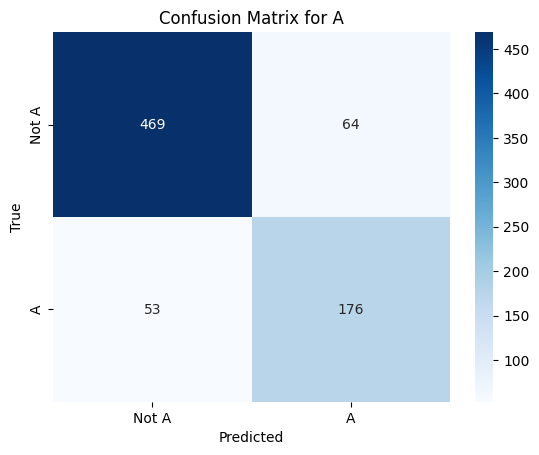

Metrics for A:
POD (Probability of Detection): 0.77
POFD (Probability of False Detection): 0.12
PSS (Peirce Skill Score): 0.65
Accuracy: 0.85




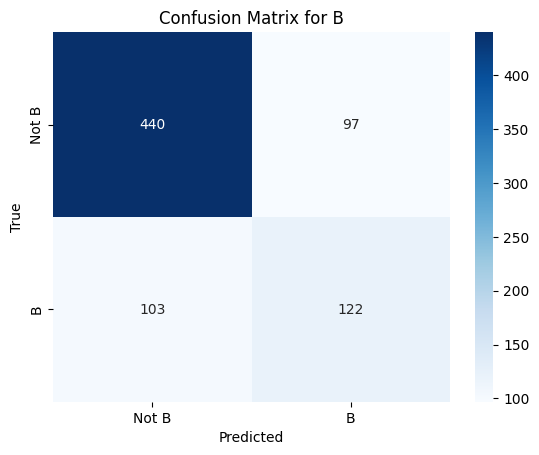

Metrics for B:
POD (Probability of Detection): 0.54
POFD (Probability of False Detection): 0.18
PSS (Peirce Skill Score): 0.36
Accuracy: 0.74




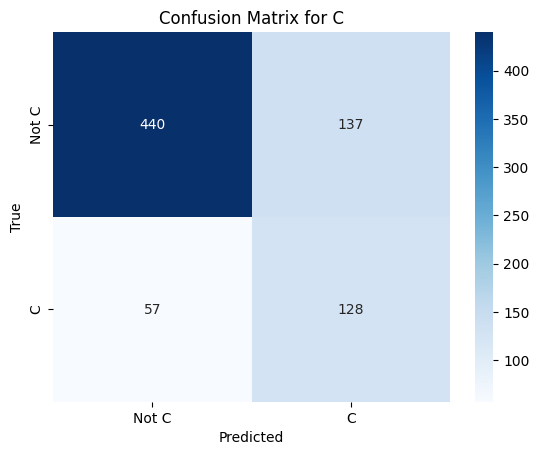

Metrics for C:
POD (Probability of Detection): 0.69
POFD (Probability of False Detection): 0.24
PSS (Peirce Skill Score): 0.45
Accuracy: 0.75




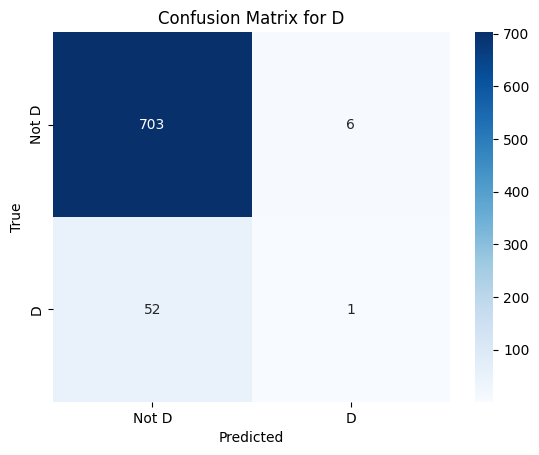

Metrics for D:
POD (Probability of Detection): 0.02
POFD (Probability of False Detection): 0.01
PSS (Peirce Skill Score): 0.01
Accuracy: 0.92




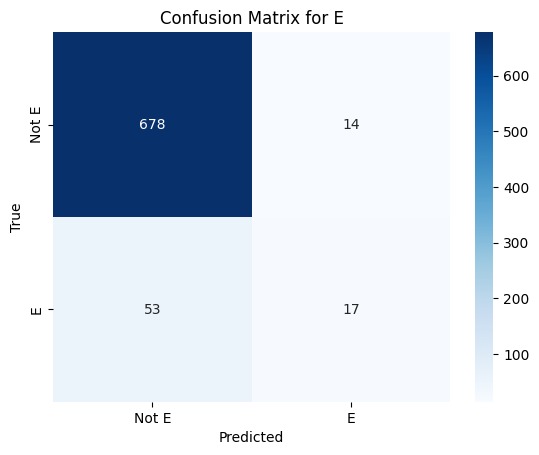

Metrics for E:
POD (Probability of Detection): 0.24
POFD (Probability of False Detection): 0.02
PSS (Peirce Skill Score): 0.22
Accuracy: 0.91


Overall Accuracy: 0.58


In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the original class labels from LabelEncoder
class_labels = label_encoder.inverse_transform(range(len(cm)))

# Function to calculate metrics
def calculate_metrics(cm):
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    pod = tp / (tp + fn) if (tp + fn) else 0  # Probability of Detection
    pofd = fp / (fp + tn) if (fp + tn) else 0  # Probability of False Detection
    pss = pod - pofd  # Peirce Skill Score
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) else 0  # Accuracy
    return pod, pofd, pss, accuracy

# Plot confusion matrices and metrics for each category
for i, label in enumerate(class_labels):
    # Construct a binary confusion matrix for the current category
    tp = cm[i, i]
    fn = np.sum(cm[i, :]) - tp
    fp = np.sum(cm[:, i]) - tp
    tn = np.sum(cm) - (fp + fn + tp)
    binary_cm = np.array([[tn, fp], [fn, tp]])

    # Calculate metrics
    pod, pofd, pss, accuracy = calculate_metrics(binary_cm)

    # Plot binary confusion matrix
    sns.heatmap(binary_cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Not ' + label, label],
                yticklabels=['Not ' + label, label])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {label}')
    plt.show()

    # Display metrics
    print(f"Metrics for {label}:")
    print(f"POD (Probability of Detection): {pod:.2f}")
    print(f"POFD (Probability of False Detection): {pofd:.2f}")
    print(f"PSS (Peirce Skill Score): {pss:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print("\n")

# Calculate overall accuracy from the combined confusion matrix
overall_accuracy = np.trace(cm) / np.sum(cm) if np.sum(cm) else 0

# Display overall accuracy
print(f"Overall Accuracy: {overall_accuracy:.2f}")

In [ ]:
def find_important_features(boosting_model, X_train, limit):
  features_all = boosting_model.feature_importances_
  dataset_all_columns = X_train.columns.values[features_all > limit].reshape(-1, 1)
  features_all_trimmed = features_all[features_all > limit].reshape(-1, 1)
  indices = np.arange(0, len(features_all), 1)[features_all > limit].reshape(-1, 1)
  ranked_features = np.concatenate([indices, dataset_all_columns, features_all_trimmed], axis = 1)
  sorted_ranked_features = sorted(ranked_features.tolist(), key = lambda kvvp: kvvp[2])[::-1]
  return sorted_ranked_features

In [ ]:
from pprint import pprint

model_size_class_important_features = find_important_features(
    boosting_model=model_size_class,
    X_train=X_train,
    limit=0.01
)
print(f"{len(model_size_class_important_features)} important features.")
pprint(model_size_class_important_features)

36 important features.
[[34, 'activity_class_Cooking and Warming', 0.06590773165225983],
 [2, 'fire_spread_rate', 0.06484922021627426],
 [71, 'true_cause_Permit Related', 0.03768225759267807],
 [79, 'fire_type_Crown', 0.037343721836805344],
 [24, 'general_cause_desc_Resident', 0.031470492482185364],
 [102, 'fuel_type_C2', 0.02931743860244751],
 [109, 'fuel_type_O1a', 0.028453674167394638],
 [39, 'activity_class_Lighting Fires', 0.02714233100414276],
 [41, 'activity_class_Operations', 0.02466866932809353],
 [17, 'general_cause_desc_Lightning', 0.021503321826457977],
 [62, 'true_cause_Burning Substance', 0.020832054316997528],
 [73, 'true_cause_Unclassified', 0.02011430822312832],
 [58, 'true_cause_Abandoned Fire', 0.019725998863577843],
 [0, 'fire_location_latitude', 0.018389377743005753],
 [43, 'activity_class_Power Lines', 0.01809276081621647],
 [61, 'true_cause_Arson Suspected', 0.01753620244562626],
 [11, 'fire_origin_Provincial Land', 0.017140982672572136],
 [53, 'activity_class_Tr

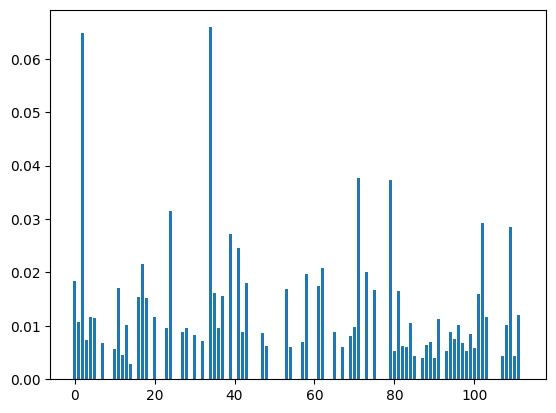

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(len(model_size_class.feature_importances_)), model_size_class.feature_importances_)
plt.show()

# XGBoost Model - Predict `size_class` (Important Features Only)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df_train_one_hot_encoded[[feature[1] for feature in model_size_class_important_features]]
y = y_fields['size_class']

# Encode categorical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
model_size_class_important_features_only = xgb.XGBClassifier(
    objective='multi:softprob',
    n_estimators=50,            # Number of boosting rounds (you can adjust this)
    learning_rate=0.1,           # Learning rate (you can adjust this)
    max_depth=4,                 # Maximum depth of each tree (you can adjust this)
    random_state=42
)

In [ ]:
model_size_class_important_features_only.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred = model_size_class_important_features_only.predict(X_test)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For nicer confusion matrix visualization

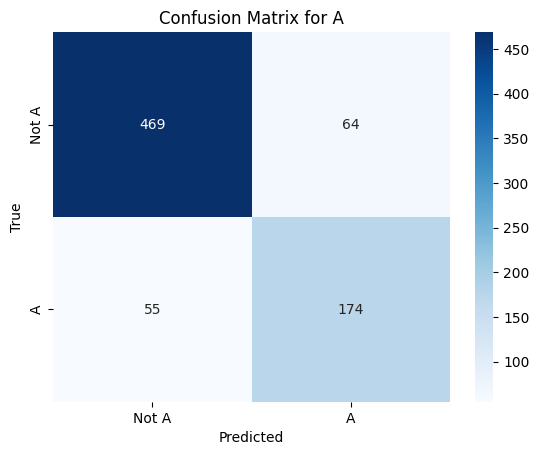

Metrics for A:
POD (Probability of Detection): 0.76
POFD (Probability of False Detection): 0.12
PSS (Peirce Skill Score): 0.64
Accuracy: 0.84




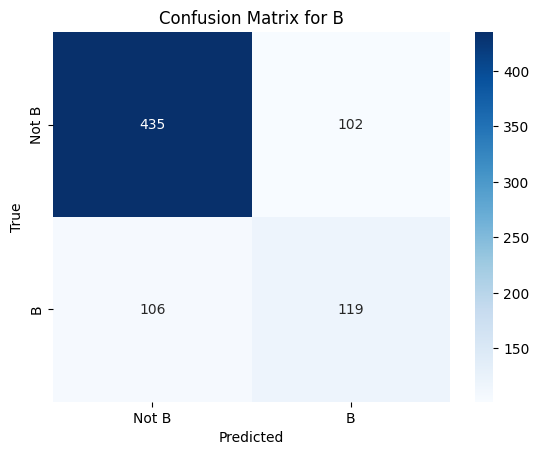

Metrics for B:
POD (Probability of Detection): 0.53
POFD (Probability of False Detection): 0.19
PSS (Peirce Skill Score): 0.34
Accuracy: 0.73




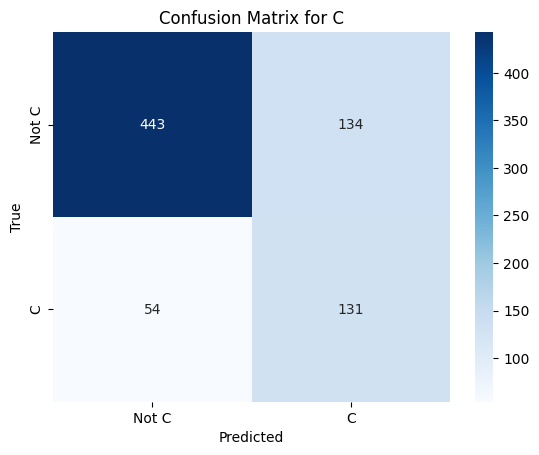

Metrics for C:
POD (Probability of Detection): 0.71
POFD (Probability of False Detection): 0.23
PSS (Peirce Skill Score): 0.48
Accuracy: 0.75




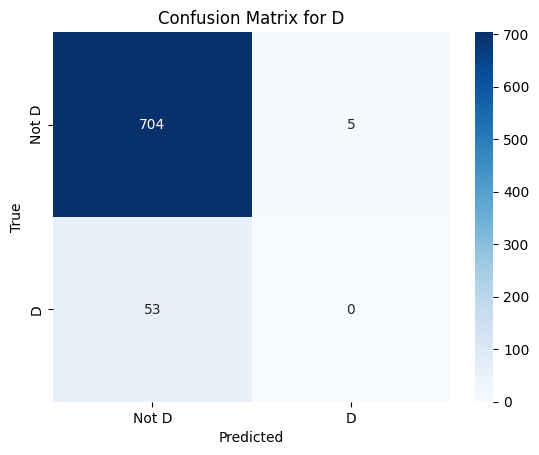

Metrics for D:
POD (Probability of Detection): 0.00
POFD (Probability of False Detection): 0.01
PSS (Peirce Skill Score): -0.01
Accuracy: 0.92




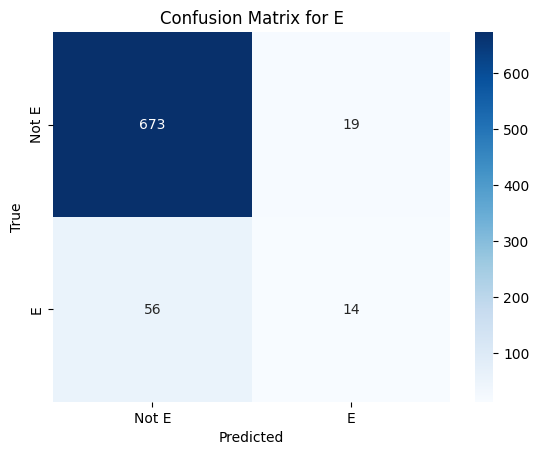

Metrics for E:
POD (Probability of Detection): 0.20
POFD (Probability of False Detection): 0.03
PSS (Peirce Skill Score): 0.17
Accuracy: 0.90


Overall Accuracy: 0.57


In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the original class labels from LabelEncoder
class_labels = label_encoder.inverse_transform(range(len(cm)))

# Function to calculate metrics
def calculate_metrics(cm):
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    pod = tp / (tp + fn) if (tp + fn) else 0  # Probability of Detection
    pofd = fp / (fp + tn) if (fp + tn) else 0  # Probability of False Detection
    pss = pod - pofd  # Peirce Skill Score
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) else 0  # Accuracy
    return pod, pofd, pss, accuracy

# Plot confusion matrices and metrics for each category
for i, label in enumerate(class_labels):
    # Construct a binary confusion matrix for the current category
    tp = cm[i, i]
    fn = np.sum(cm[i, :]) - tp
    fp = np.sum(cm[:, i]) - tp
    tn = np.sum(cm) - (fp + fn + tp)
    binary_cm = np.array([[tn, fp], [fn, tp]])

    # Calculate metrics
    pod, pofd, pss, accuracy = calculate_metrics(binary_cm)

    # Plot binary confusion matrix
    sns.heatmap(binary_cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Not ' + label, label],
                yticklabels=['Not ' + label, label])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {label}')
    plt.show()

    # Display metrics
    print(f"Metrics for {label}:")
    print(f"POD (Probability of Detection): {pod:.2f}")
    print(f"POFD (Probability of False Detection): {pofd:.2f}")
    print(f"PSS (Peirce Skill Score): {pss:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print("\n")

# Calculate overall accuracy from the combined confusion matrix
overall_accuracy = np.trace(cm) / np.sum(cm) if np.sum(cm) else 0

# Display overall accuracy
print(f"Overall Accuracy: {overall_accuracy:.2f}")

In [ ]:
from pprint import pprint

model_size_class_important_features_only_important_features_low_limit = find_important_features(
    boosting_model=model_size_class_important_features_only,
    X_train=X_train,
    limit=0.01
)
print(f"{len(model_size_class_important_features_only_important_features_low_limit)} important features.")
pprint(model_size_class_important_features_only_important_features_low_limit)

34 important features.
[[1, 'fire_spread_rate', 0.09779509902000427],
 [0, 'activity_class_Cooking and Warming', 0.07954554259777069],
 [2, 'true_cause_Permit Related', 0.058321647346019745],
 [3, 'fire_type_Crown', 0.043396227061748505],
 [7, 'activity_class_Lighting Fires', 0.0417826771736145],
 [5, 'fuel_type_C2', 0.03959920257329941],
 [9, 'general_cause_desc_Lightning', 0.03703954815864563],
 [6, 'fuel_type_O1a', 0.036636609584093094],
 [11, 'true_cause_Unclassified', 0.03486533463001251],
 [8, 'activity_class_Operations', 0.033529043197631836],
 [20, 'activity_class_Debris Disposal', 0.0298250000923872],
 [12, 'true_cause_Abandoned Fire', 0.029371708631515503],
 [17, 'activity_class_Transportation', 0.026705250144004822],
 [13, 'fire_location_latitude', 0.026494383811950684],
 [21, 'fuel_type_C1', 0.02550463005900383],
 [10, 'true_cause_Burning Substance', 0.023399947211146355],
 [16, 'fire_origin_Provincial Land', 0.02245618775486946],
 [18, 'true_cause_Unsafe Fire', 0.022032763

In [ ]:
from pprint import pprint

model_size_class_important_features_only_important_features_high_limit = find_important_features(
    boosting_model=model_size_class_important_features_only,
    X_train=X_train,
    limit=0.03
)
print(f"{len(model_size_class_important_features_only_important_features_high_limit)} important features.")
pprint(model_size_class_important_features_only_important_features_high_limit)

10 important features.
[[1, 'fire_spread_rate', 0.09779509902000427],
 [0, 'activity_class_Cooking and Warming', 0.07954554259777069],
 [2, 'true_cause_Permit Related', 0.058321647346019745],
 [3, 'fire_type_Crown', 0.043396227061748505],
 [7, 'activity_class_Lighting Fires', 0.0417826771736145],
 [5, 'fuel_type_C2', 0.03959920257329941],
 [9, 'general_cause_desc_Lightning', 0.03703954815864563],
 [6, 'fuel_type_O1a', 0.036636609584093094],
 [11, 'true_cause_Unclassified', 0.03486533463001251],
 [8, 'activity_class_Operations', 0.033529043197631836]]


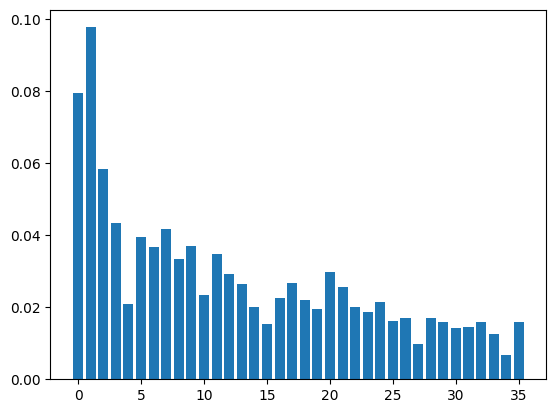

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(len(model_size_class_important_features_only.feature_importances_)), model_size_class_important_features_only.feature_importances_)
plt.show()

# XGBoost Model - Predict `size_class` (Most Important Features Only)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df_train_one_hot_encoded[[feature[1] for feature in model_size_class_important_features_only_important_features_high_limit]]
y = y_fields['size_class']

# Encode categorical labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

In [ ]:
model_size_class_most_important_features_only = xgb.XGBClassifier(
    objective='multi:softprob',
    n_estimators=50,            # Number of boosting rounds (you can adjust this)
    learning_rate=0.1,           # Learning rate (you can adjust this)
    max_depth=4,                 # Maximum depth of each tree (you can adjust this)
    random_state=42
)

In [ ]:
model_size_class_most_important_features_only.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_pred = model_size_class_most_important_features_only.predict(X_test)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns  # For nicer confusion matrix visualization

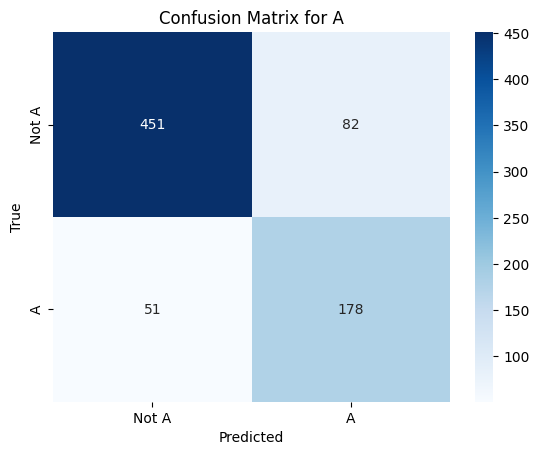

Metrics for A:
POD (Probability of Detection): 0.78
POFD (Probability of False Detection): 0.15
PSS (Peirce Skill Score): 0.62
Accuracy: 0.83




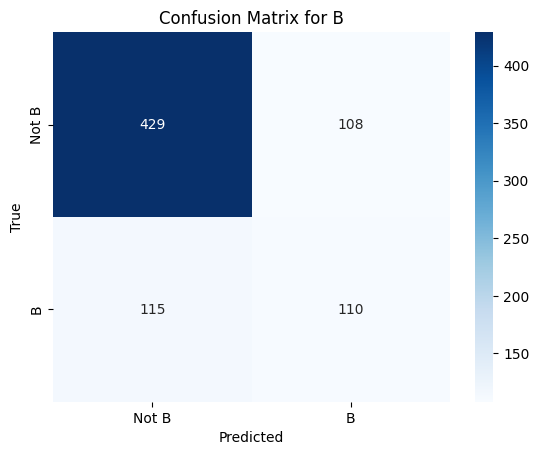

Metrics for B:
POD (Probability of Detection): 0.49
POFD (Probability of False Detection): 0.20
PSS (Peirce Skill Score): 0.29
Accuracy: 0.71




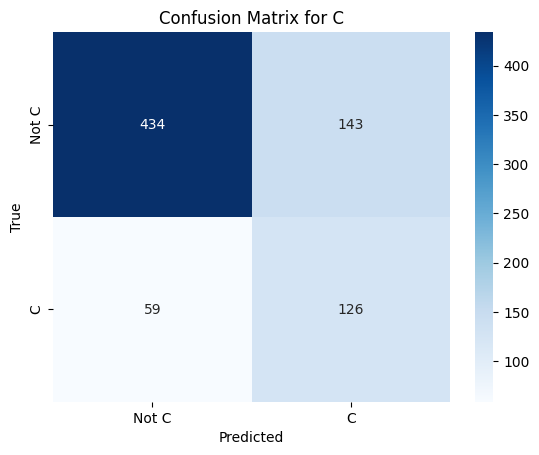

Metrics for C:
POD (Probability of Detection): 0.68
POFD (Probability of False Detection): 0.25
PSS (Peirce Skill Score): 0.43
Accuracy: 0.73




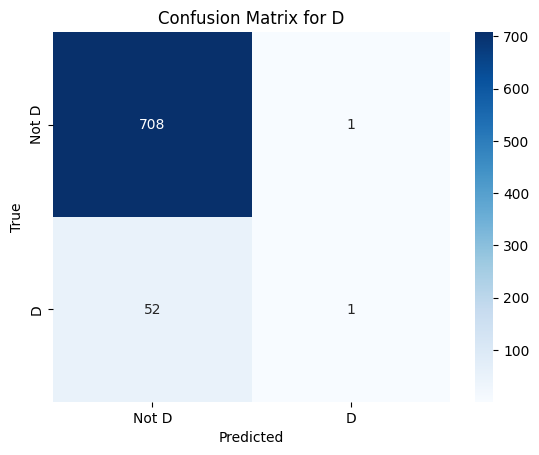

Metrics for D:
POD (Probability of Detection): 0.02
POFD (Probability of False Detection): 0.00
PSS (Peirce Skill Score): 0.02
Accuracy: 0.93




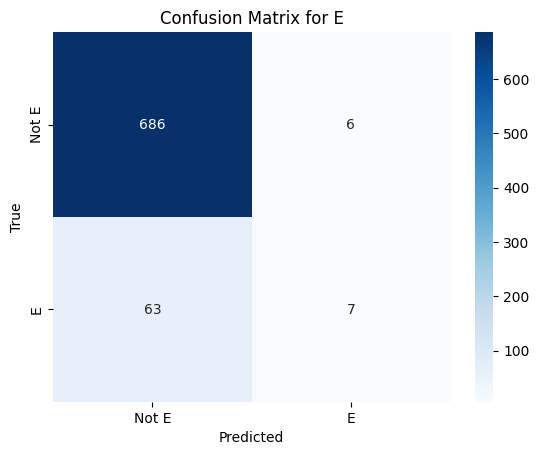

Metrics for E:
POD (Probability of Detection): 0.10
POFD (Probability of False Detection): 0.01
PSS (Peirce Skill Score): 0.09
Accuracy: 0.91


Overall Accuracy: 0.55


In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Get the original class labels from LabelEncoder
class_labels = label_encoder.inverse_transform(range(len(cm)))

# Function to calculate metrics
def calculate_metrics(cm):
    tp = cm[1, 1]
    tn = cm[0, 0]
    fp = cm[0, 1]
    fn = cm[1, 0]
    pod = tp / (tp + fn) if (tp + fn) else 0  # Probability of Detection
    pofd = fp / (fp + tn) if (fp + tn) else 0  # Probability of False Detection
    pss = pod - pofd  # Peirce Skill Score
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) else 0  # Accuracy
    return pod, pofd, pss, accuracy

# Plot confusion matrices and metrics for each category
for i, label in enumerate(class_labels):
    # Construct a binary confusion matrix for the current category
    tp = cm[i, i]
    fn = np.sum(cm[i, :]) - tp
    fp = np.sum(cm[:, i]) - tp
    tn = np.sum(cm) - (fp + fn + tp)
    binary_cm = np.array([[tn, fp], [fn, tp]])

    # Calculate metrics
    pod, pofd, pss, accuracy = calculate_metrics(binary_cm)

    # Plot binary confusion matrix
    sns.heatmap(binary_cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=['Not ' + label, label],
                yticklabels=['Not ' + label, label])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {label}')
    plt.show()

    # Display metrics
    print(f"Metrics for {label}:")
    print(f"POD (Probability of Detection): {pod:.2f}")
    print(f"POFD (Probability of False Detection): {pofd:.2f}")
    print(f"PSS (Peirce Skill Score): {pss:.2f}")
    print(f"Accuracy: {accuracy:.2f}")
    print("\n")

# Calculate overall accuracy from the combined confusion matrix
overall_accuracy = np.trace(cm) / np.sum(cm) if np.sum(cm) else 0

# Display overall accuracy
print(f"Overall Accuracy: {overall_accuracy:.2f}")

In [ ]:
from pprint import pprint

model_size_class_most_important_features_only_important_features = find_important_features(
    boosting_model=model_size_class_most_important_features_only,
    X_train=X_train,
    limit=0.01
)
print(f"{len(model_size_class_most_important_features_only_important_features)} important features.")
pprint(model_size_class_most_important_features_only_important_features)

10 important features.
[[1, 'activity_class_Cooking and Warming', 0.20280878245830536],
 [0, 'fire_spread_rate', 0.18928468227386475],
 [3, 'fire_type_Crown', 0.1426413208246231],
 [2, 'true_cause_Permit Related', 0.10759127885103226],
 [7, 'fuel_type_O1a', 0.06960204243659973],
 [6, 'general_cause_desc_Lightning', 0.06803453713655472],
 [4, 'activity_class_Lighting Fires', 0.06154618784785271],
 [5, 'fuel_type_C2', 0.060326386243104935],
 [8, 'true_cause_Unclassified', 0.04984394088387489],
 [9, 'activity_class_Operations', 0.04832085222005844]]


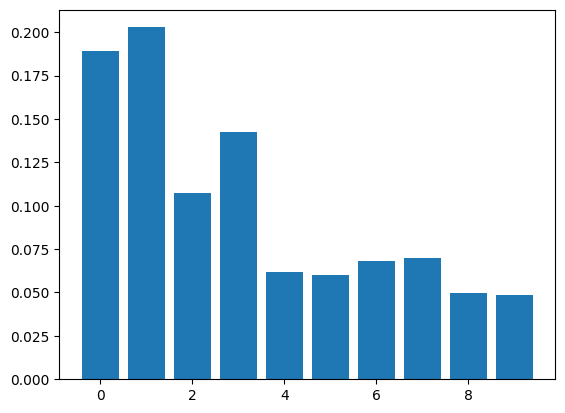

In [ ]:
import matplotlib.pyplot as plt

plt.bar(range(len(model_size_class_most_important_features_only.feature_importances_)), model_size_class_most_important_features_only.feature_importances_)
plt.show()

In [ ]:
X_train

,fire_spread_rate,activity_class_Cooking and Warming,true_cause_Permit Related,fire_type_Crown,activity_class_Lighting Fires,fuel_type_C2,general_cause_desc_Lightning,fuel_type_O1a,true_cause_Unclassified,activity_class_Operations
10222,0.000000,0,0,0,0,1,0,0,0,0
10825,2.500000,0,0,0,0,0,0,0,0,1
1350,0.000000,0,0,0,0,1,0,0,0,0
16862,4.000000,0,0,0,0,1,1,0,1,0
246,3.000000,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
1130,0.000000,0,0,0,0,0,0,1,1,0
1294,2.349164,1,0,0,0,1,0,0,0,0
860,0.000000,0,0,0,0,0,1,0,1,0
18177,8.000000,0,0,0,0,0,0,0,0,0


# Save, Load, and Run the Model

In [ ]:
X_example = X_test[[feature[1] for feature in model_size_class_important_features_only_important_features_high_limit]]

In [ ]:
X_example

,fire_spread_rate,activity_class_Cooking and Warming,true_cause_Permit Related,fire_type_Crown,activity_class_Lighting Fires,fuel_type_C2,general_cause_desc_Lightning,fuel_type_O1a,true_cause_Unclassified,activity_class_Operations
1011,0.5,0,0,0,0,0,1,0,1,0
13584,1.0,0,0,0,0,0,1,0,1,0
15624,2.0,0,0,0,0,1,1,0,1,0
897,0.0,0,0,0,0,1,1,0,1,0
3638,0.0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
12360,4.0,0,0,0,0,1,1,0,1,0
644,0.0,0,0,0,0,0,1,0,1,0
15566,0.5,0,0,0,0,0,1,0,1,0
2870,6.0,0,0,0,0,0,1,0,1,0


In [ ]:
y_example = y_test

In [ ]:
y_example

array([0, 2, 2, 0, 1, 0, 0, 1, 0, 2, 0, 0, 0, 0, 2, 0, 1, 2, 3, 3, 4, 3,
       0, 2, 3, 3, 3, 1, 4, 2, 0, 4, 2, 0, 2, 1, 0, 3, 2, 0, 1, 3, 3, 3,
       0, 1, 4, 3, 2, 2, 3, 2, 0, 1, 0, 0, 1, 0, 4, 4, 0, 4, 0, 0, 0, 0,
       2, 0, 4, 3, 0, 1, 0, 4, 2, 1, 0, 1, 3, 0, 0, 2, 2, 0, 3, 1, 0, 2,
       1, 2, 1, 1, 0, 0, 1, 1, 0, 2, 1, 3, 2, 0, 0, 0, 0, 1, 0, 4, 0, 1,
       0, 0, 0, 1, 1, 0, 3, 1, 1, 0, 1, 3, 2, 2, 1, 3, 0, 0, 2, 1, 4, 0,
       1, 2, 1, 4, 3, 2, 3, 0, 0, 1, 1, 2, 4, 1, 4, 1, 4, 0, 0, 2, 0, 2,
       1, 0, 1, 0, 1, 0, 1, 2, 2, 2, 0, 1, 1, 2, 1, 3, 1, 0, 4, 1, 0, 2,
       0, 1, 0, 0, 0, 2, 0, 2, 0, 2, 1, 3, 1, 1, 0, 2, 1, 2, 1, 0, 0, 1,
       0, 0, 4, 4, 1, 3, 1, 3, 4, 0, 2, 0, 2, 2, 2, 0, 2, 1, 0, 1, 2, 4,
       0, 0, 0, 4, 1, 0, 4, 1, 0, 1, 0, 2, 2, 1, 2, 2, 0, 1, 0, 2, 2, 1,
       0, 2, 2, 2, 0, 2, 2, 0, 1, 1, 1, 1, 1, 1, 4, 0, 0, 1, 1, 2, 1, 3,
       4, 1, 1, 2, 3, 1, 0, 4, 4, 1, 1, 4, 0, 1, 3, 1, 1, 1, 0, 2, 0, 1,
       2, 0, 0, 2, 2, 1, 0, 2, 1, 0, 2, 2, 3, 4, 1,

In [ ]:
import pickle

# Save the model to disk
with open('model_size_class_most_important_features_only.pkl', 'wb') as file:
    pickle.dump(model_size_class_most_important_features_only, file)

In [ ]:
# Load the model from disk
with open('model_size_class_most_important_features_only.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

In [ ]:
# Making predictions
example_pred = loaded_model.predict(X_example)

In [ ]:
example_pred

array([1, 1, 2, 0, 0, 0, 0, 1, 0, 2, 1, 1, 0, 0, 1, 0, 2, 2, 2, 1, 2, 2,
       0, 2, 2, 2, 0, 1, 2, 2, 0, 2, 2, 0, 0, 1, 0, 2, 2, 1, 1, 2, 2, 2,
       1, 1, 1, 2, 2, 1, 2, 1, 1, 1, 0, 0, 1, 0, 1, 2, 0, 2, 0, 0, 0, 0,
       2, 0, 2, 2, 0, 2, 0, 2, 2, 1, 0, 1, 2, 0, 0, 1, 2, 0, 1, 2, 0, 2,
       0, 2, 0, 1, 0, 0, 2, 2, 0, 0, 1, 2, 1, 0, 0, 0, 1, 1, 0, 1, 1, 2,
       0, 0, 2, 0, 1, 0, 2, 1, 0, 0, 2, 2, 0, 2, 1, 2, 0, 1, 2, 1, 2, 0,
       1, 1, 0, 1, 2, 1, 2, 0, 0, 0, 2, 2, 2, 2, 1, 0, 2, 0, 0, 0, 0, 1,
       0, 0, 2, 0, 1, 1, 0, 2, 2, 2, 0, 0, 1, 2, 1, 2, 1, 0, 2, 2, 0, 2,
       0, 0, 0, 0, 0, 4, 1, 2, 0, 2, 2, 3, 1, 1, 0, 0, 2, 0, 2, 0, 0, 1,
       0, 1, 1, 2, 0, 2, 1, 1, 0, 0, 2, 0, 2, 1, 1, 1, 1, 2, 0, 2, 2, 4,
       0, 0, 0, 2, 1, 0, 2, 1, 0, 1, 0, 2, 2, 2, 2, 2, 0, 0, 0, 2, 1, 1,
       0, 2, 2, 2, 0, 2, 2, 0, 1, 2, 2, 1, 0, 1, 2, 0, 0, 0, 2, 2, 1, 0,
       2, 1, 2, 2, 2, 1, 1, 2, 1, 1, 1, 2, 0, 1, 2, 2, 1, 0, 0, 2, 0, 0,
       2, 0, 0, 2, 2, 0, 0, 2, 1, 0, 2, 2, 2, 2, 2,

In [ ]:
from google.colab import files

files.download('model_size_class_most_important_features_only.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>